In [1]:
!pip uninstall xgboost
!pip install xgboost-0.80-py2.py3-none-manylinux1_x86_64.whl

Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.6/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Processing ./xgboost-0.80-py2.py3-none-manylinux1_x86_64.whl


In [0]:
import numpy as np
import pandas as pd

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
data = pd.read_csv('drive/My Drive/train.csv')
(nb_sample,nb_feature) = data.shape
print(data.shape)
data.head(5)

(58881, 129)


,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,InsuredInfo_8,InsuredInfo_9,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,A8,26,0.230769,2,3,1,0.492537,0.563636,0.225941,0.510720,0.0244,9,1,0.0,2,0.05,2,2,3,3,1,1,Female,NaN,Muslim,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.492958,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
1,1,D2,26,1.000000,3,3,1,0.671642,0.781818,0.326360,0.453033,0.5000,3,1,0.5,2,1.00,1,2,8,3,1,1,Male,NaN,NaN,2,1,3,1,0.006667,1,3,2,2,NaN,0.490196,NaN,0.589286,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,1,D2,26,0.230769,2,3,1,0.626866,0.745455,0.393305,0.598310,0.0400,9,1,0.0,2,0.60,1,2,4,3,1,1,Male,Caucasian,Jewish,1,3,3,1,0.000833,1,1,2,3,NaN,0.558824,NaN,0.598214,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,D4,26,0.230769,2,3,1,0.268657,0.690909,0.246862,0.410638,0.0300,9,1,0.0,2,0.00,1,2,6,2,1,1,Female,NaN,NaN,2,1,1,3,NaN,3,2,3,2,0.536232,NaN,0.478873,NaN,12.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,1,E1,10,0.230769,2,3,1,0.641791,0.581818,0.466527,1.000000,0.0280,9,1,0.0,3,1.00,1,2,8,3,1,1,Female,NaN,NaN,2,1,3,1,0.000039,1,3,2,2,NaN,0.647059,NaN,0.160714,1.0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2


### Plan:
##### a. According to EDA, we decide to preprocess our raw training and test data as following steps:
    1. Delete samples with 14 and 15 missing featrues;
    2. Delete directly the features that have more than 70% missing values;
    3. Encode object-type data;
    4. Fill missing values by mean for other features;
    5. See variance again and delete top5 features with the lowest variance;
    6. See correlation again to delete top5 features with the lowest correlation to the target;
##### b.  Set up a XGBoost model to see the performance and then select important features in using feature importance fonction.
    1. We deceide to use 3-fold crossing validation to reduce uncertainty and aviod overfitting;
    2. Select different number of improtant features to test model performance;
##### c.  Chosse the best features and do preprocessing (only step 1 and 4)
##### d. Predict results in using 3 models trained from 3-fold CV and then do a voting

### Data Preprocessing:

##### delete samples with 14 and 15 missing featrues

In [154]:
nb_delete_1415 = 0
for i in range(nb_sample):
    if i < (nb_sample-nb_delete_1415):
        nb_missing = data.iloc[i,:].isnull().sum()
        if nb_missing >= 13:
            data.drop(index=[i],inplace=True)
            nb_delete_1415+=1
    else:
        break
print('totally delete: ',nb_delete_1415, 'samples')
data.reset_index(drop = True,inplace = True)
data.head(5)

totally delete:  29 samples


,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,InsuredInfo_8,InsuredInfo_9,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,A8,26,0.230769,2,3,1,0.492537,0.563636,0.225941,0.510720,0.0244,9,1,0.0,2,0.05,2,2,3,3,1,1,Female,NaN,Muslim,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.492958,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
1,1,D2,26,1.000000,3,3,1,0.671642,0.781818,0.326360,0.453033,0.5000,3,1,0.5,2,1.00,1,2,8,3,1,1,Male,NaN,NaN,2,1,3,1,0.006667,1,3,2,2,NaN,0.490196,NaN,0.589286,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,1,D2,26,0.230769,2,3,1,0.626866,0.745455,0.393305,0.598310,0.0400,9,1,0.0,2,0.60,1,2,4,3,1,1,Male,Caucasian,Jewish,1,3,3,1,0.000833,1,1,2,3,NaN,0.558824,NaN,0.598214,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,D4,26,0.230769,2,3,1,0.268657,0.690909,0.246862,0.410638,0.0300,9,1,0.0,2,0.00,1,2,6,2,1,1,Female,NaN,NaN,2,1,1,3,NaN,3,2,3,2,0.536232,NaN,0.478873,NaN,12.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,1,E1,10,0.230769,2,3,1,0.641791,0.581818,0.466527,1.000000,0.0280,9,1,0.0,3,1.00,1,2,8,3,1,1,Female,NaN,NaN,2,1,3,1,0.000039,1,3,2,2,NaN,0.647059,NaN,0.160714,1.0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2


##### delete directly the features that have more than 70% missing values

In [155]:
# According to EDA, we will delete the features: 
#Medical_History_10,Medical_History_32,Medical_History_24,InsuredInfo_8,Medical_History_15,InsuredInfo_9,Family_Hist_5 
import gc
del data['Medical_History_10'],data['Medical_History_32'],data['Medical_History_24'],data['InsuredInfo_8'],data['Medical_History_15'],data['InsuredInfo_9'],data['Family_Hist_5']
gc.collect()

11

##### encode object-type data

In [156]:
print(data[data.columns[(data.dtypes == 'object')==True]].columns)
print(data['Product_Info_2'].unique())
print(data['InsuredInfo_7'].unique())

Index(['Product_Info_2', 'InsuredInfo_7'], dtype='object')
['A8' 'D2' 'D4' 'E1' 'A3' 'A6' 'B2' 'D1' 'D3' 'A2' 'A1' 'C4' 'B1' 'A5'
 'C3' 'C1' 'A7' 'A4' 'C2']
['Female' 'Male']


In [157]:
# As we can see above, we decide to:
# onehot encoding: InsuredInfo_7; label encoding: Product_Info_2
data = data.join(pd.get_dummies(data['InsuredInfo_7']))
del data['InsuredInfo_7']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(data['Product_Info_2'])
data['Product_Info_2'] = le.transform(data['Product_Info_2'])
data.head(5)

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,...,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Female,Male
0,1,7,26,0.230769,2,3,1,0.492537,0.563636,0.225941,0.510720,0.0244,9,1,0.0,2,0.05,2,2,3,3,1,1,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.492958,0.0,112,2,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1,0
1,1,15,26,1.000000,3,3,1,0.671642,0.781818,0.326360,0.453033,0.5000,3,1,0.5,2,1.00,1,2,8,3,1,1,2,1,3,1,0.006667,1,3,2,2,NaN,0.490196,NaN,4.0,161,2,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1
2,1,15,26,0.230769,2,3,1,0.626866,0.745455,0.393305,0.598310,0.0400,9,1,0.0,2,0.60,1,2,4,3,1,1,1,3,3,1,0.000833,1,1,2,3,NaN,0.558824,NaN,3.0,3,2,1,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,17,26,0.230769,2,3,1,0.268657,0.690909,0.246862,0.410638,0.0300,9,1,0.0,2,0.00,1,2,6,2,1,1,2,1,1,3,NaN,3,2,3,2,0.536232,NaN,0.478873,12.0,261,2,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0
4,1,18,10,0.230769,2,3,1,0.641791,0.581818,0.466527,1.000000,0.0280,9,1,0.0,3,1.00,1,2,8,3,1,1,2,1,3,1,0.000039,1,3,2,2,NaN,0.647059,NaN,1.0,112,3,2,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2,1,0


##### Fill missing values by mean for other features;

In [158]:
missing_features = pd.DataFrame(data.dtypes,columns=['dtypes'])
missing_features = missing_features.reset_index()
missing_features['Name'] = missing_features['index']
del missing_features['index']
missing_features.reset_index(drop=True,inplace=True)
missing_features = missing_features[data.isnull().sum().values!=0]
missing_features

,dtypes,Name
11,float64,Employment_Info_1
14,float64,Employment_Info_4
16,float64,Employment_Info_6
27,float64,Insurance_History_5
32,float64,Family_Hist_2
33,float64,Family_Hist_3
34,float64,Family_Hist_4
35,float64,Medical_History_1


In [159]:
# as they are all float data, we can then fill them by mean directly
data.fillna(data.mean()[missing_features.Name],inplace=True)
print('now we have ',data.isnull().sum().values.sum(),' missing value')

now we have  0  missing value


##### See variance again and delete top5 features with the lowest variance

In [160]:
tabel_var = data[data.columns].var().sort_values(ascending=True)
tabel_var = tabel_var.head(5)
print(tabel_var)
tabel_var.reset_index()
for column in tabel_var.index.tolist():
    del data[column]
gc.collect()

Insurance_History_5    0.000031
Employment_Info_4      0.000960
Medical_History_35     0.004108
Medical_History_38     0.004819
Ht                     0.005513
dtype: float64


44

##### See correlation again to delete top5 features with the lowest correlation to the targe

In [161]:
X_temp = data
X_temp = X_temp.corr()
tabel_corr = abs(X_temp[['Response']]).sort_values(by=['Response'],ascending=True)
tabel_corr = tabel_corr.head(5)
print(tabel_corr)
tabel_corr.reset_index()
for column in tabel_corr.index.tolist():
    del data[column]
del X_temp
gc.collect()

                     Response
Insurance_History_4  0.000594
Medical_History_25   0.000598
Medical_History_36   0.000748
Medical_History_26   0.000777
Insurance_History_1  0.000885


33

In [162]:
print(data.shape)
y_data = data['Response']
del data['Response']
gc.collect()

(58852, 113)


0

### Data Modeling

#### Plan:
    a. Seperate training set into training set and validation set (used in step b,c);
    b. Use some simple models like SVC, KNN to see the baseline;
    c. Use some avanced models like random forest;
    d. If the result isn't good enough, we will try to use xgboost and cross validation to make a voting.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data, y_data, 
                                                                test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)

(50024, 112)
(8828, 112)


##### SVC

In [0]:
# # wait for five minutes still no result, maybe it's memory issue
# from sklearn.svm import SVC
# clf = SVC(C=0.5)
# clf.fit(X_train,y_train)
# print('validation set presicion:',clf.score(X_validation,y_validation))
# print('training set precision:',clf.score(X_train,y_train))

##### KNN

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_validation)
print('validation set presicion:',accuracy_score(y_validation, y_pred))
y_pred = clf.predict(X_train)
print('training set precision:',accuracy_score(y_train, y_pred))

validation set presicion: 0.3192115994562755
training set precision: 0.48288821365744444


##### Random Forest

In [33]:
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=2000)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

validation set presicion: 0.5133665609424558
training set precision: 0.5663681432912202


##### XGBoost

In [0]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_validation.reset_index(drop=True,inplace=True)

In [18]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 0
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []
for tr_idx, val_idx in tqdm(kf.split(X_train,y_train)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = X_train[list(X_train)].iloc[tr_idx], y_train[tr_idx]
        vl_x, vl_y = X_train[list(X_train)].iloc[val_idx], y_train[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        clf = xgb.XGBClassifier(n_estimators=2000,
                                learning_rate=0.01,
                                feature_fraction=0.9,
                                subsample=0.25,  # batches of 25% of the data
                                subsample_freq=1,
                                lambda_l2=0.2,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models.append(clf)

0it [00:00, ?it/s]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.503652	validation_1-merror:0.514473
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.47833	validation_1-merror:0.488645
[500]	validation_0-merror:0.469268	validation_1-merror:0.480729
[750]	validation_0-merror:0.458313	validation_1-merror:0.473853
[1000]	validation_0-merror:0.45117	validation_1-merror:0.468655
[1250]	validation_0-merror:0.444747	validation_1-merror:0.465776
[1500]	validation_0-merror:0.438989	validation_1-merror:0.463617
[1750]	validation_0-merror:0.433579	validation_1-merror:0.461778
[1999]	validation_0-merror:0.428488	validation_1-merror:0.460419


1it [01:10, 70.42s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.508369	validation_1-merror:0.511514
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.47897	validation_1-merror:0.483848
[500]	validation_0-merror:0.467829	validation_1-merror:0.477371
[750]	validation_0-merror:0.45898	validation_1-merror:0.473373
[1000]	validation_0-merror:0.450344	validation_1-merror:0.471294
[1250]	validation_0-merror:0.444453	validation_1-merror:0.468335
[1500]	validation_0-merror:0.438483	validation_1-merror:0.466176
[1750]	validation_0-merror:0.434245	validation_1-merror:0.462498
[1999]	validation_0-merror:0.430487	validation_1-merror:0.461139


2it [02:14, 68.44s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.504744	validation_1-merror:0.509196
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.477584	validation_1-merror:0.482408
[500]	validation_0-merror:0.468548	validation_1-merror:0.474412
[750]	validation_0-merror:0.45922	validation_1-merror:0.466096
[1000]	validation_0-merror:0.452396	validation_1-merror:0.460739
[1250]	validation_0-merror:0.445866	validation_1-merror:0.45754
[1500]	validation_0-merror:0.439442	validation_1-merror:0.455222
Stopping. Best iteration:
[1435]	validation_0-merror:0.441175	validation_1-merror:0.454982



3it [03:04, 63.01s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.496535	validation_1-merror:0.494962
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.480356	validation_1-merror:0.47849
[500]	validation_0-merror:0.471187	validation_1-merror:0.471454
[750]	validation_0-merror:0.460099	validation_1-merror:0.467136
[1000]	validation_0-merror:0.451943	validation_1-merror:0.463298
[1250]	validation_0-merror:0.446133	validation_1-merror:0.459539
[1500]	validation_0-merror:0.440349	validation_1-merror:0.45842
Stopping. Best iteration:
[1376]	validation_0-merror:0.442694	validation_1-merror:0.45794



4it [03:53, 58.64s/it]


In [19]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 4 models hard voting:',accuracy_score(y_validation, res))

test set precision 4 models hard voting: 0.5414589941096511


In [20]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
res_preds.append(clf_rf.predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 5 models hard voting:',accuracy_score(y_validation, res))

test set precision 5 models hard voting: 0.542931581332125


#### Select features that appear in the top 20 rankings of feature importance of tree-based models (1 random forest model and 4 xgboost models) 

In [36]:
# random forest feature importance rank
feat_labels = X_train.columns
rf_importances = clf_rf.feature_importances_
indices = np.argsort(rf_importances)[::-1]
rf_important_features = []
for f in range(50):
    rf_important_features.append(feat_labels[indices[f]])
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], rf_importances[indices[f]]))

 1) BMI                            0.199846
 2) Wt                             0.131212
 3) Medical_History_4              0.084770
 4) Medical_History_23             0.070095
 5) Product_Info_4                 0.069168
 6) Medical_Keyword_15             0.064412
 7) Medical_Keyword_3              0.030821
 8) Ins_Age                        0.030384
 9) Male                           0.019738
10) Female                         0.019179
11) Family_Hist_4                  0.017882
12) Medical_History_39             0.017842
13) Product_Info_2                 0.015222
14) Family_Hist_2                  0.014319
15) Family_Hist_3                  0.012372
16) Employment_Info_1              0.011982
17) Medical_History_1              0.011337
18) Employment_Info_6              0.009097
19) Medical_History_30             0.007940
20) Medical_History_2              0.007576
21) Medical_History_33             0.007232
22) Medical_Keyword_23             0.007103
23) Employment_Info_2           

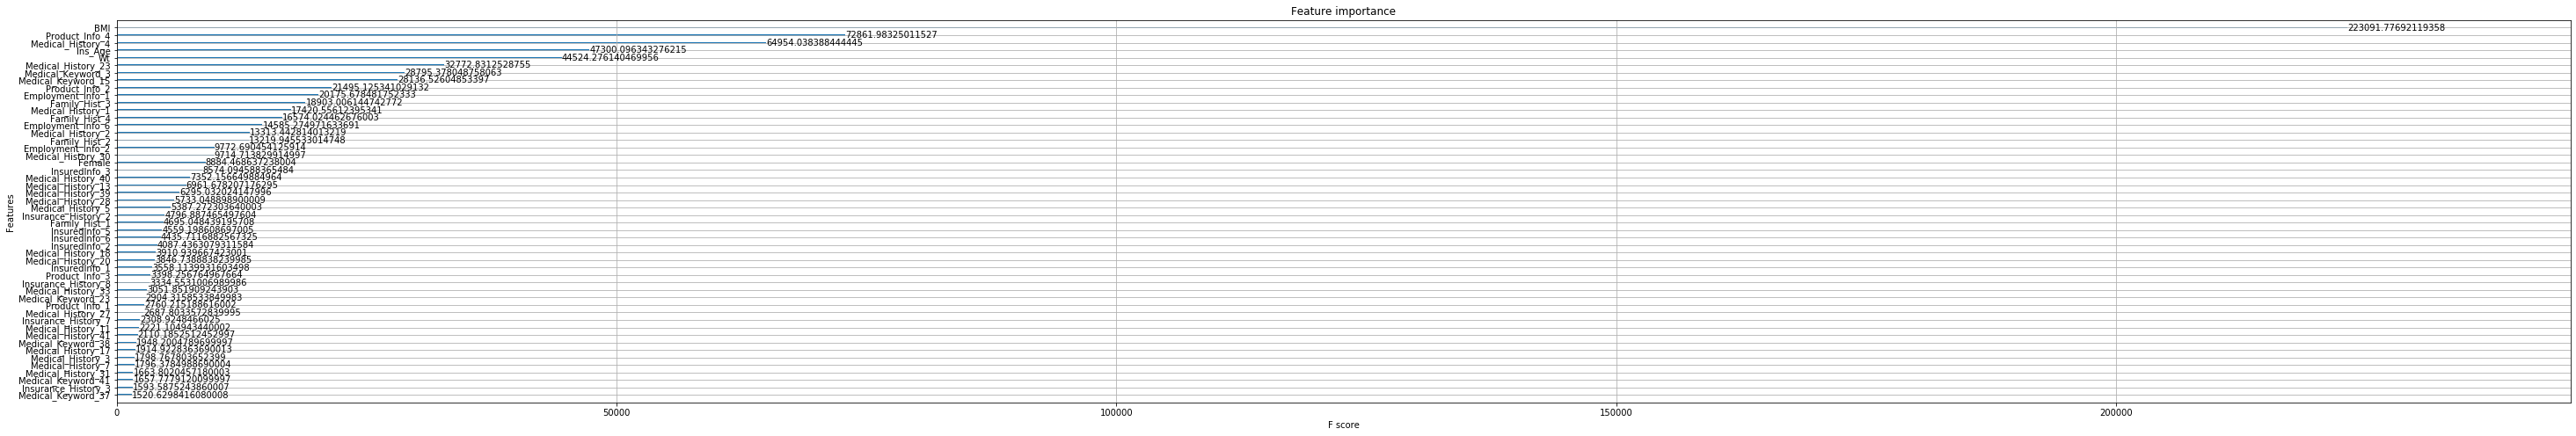

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (50, 8)
_ = xgb.plot_importance(models[0], importance_type='total_gain',max_num_features=50)

In [0]:
# xgb_importance1=pd.DataFrame({'importance':models[0].feature_importances_,'var':data.columns})
feature_importance = [[],[],[],[]]
for i in range(4):
  xgb_importance = models[i].get_booster().get_score(importance_type="total_gain")
  xgb_importance = sorted(xgb_importance.items(),key=lambda item:item[-1],reverse=True)
  for item in xgb_importance:
    feature_importance[i].append(item[0])
  feature_importance[i] = feature_importance[i][:40]

In [47]:
important_features = [x for x in feature_importance[0] if (x in feature_importance[1])and(x in feature_importance[2])and(x in feature_importance[3]and(x in rf_important_features))]
# important_features = [x for x in feature_importance[0] if (x in feature_importance[1])and(x in feature_importance[2])and(x in feature_importance[3])]
print(important_features)
print(len(important_features),'features')

['BMI', 'Product_Info_4', 'Medical_History_4', 'Ins_Age', 'Wt', 'Medical_History_23', 'Medical_Keyword_3', 'Medical_Keyword_15', 'Product_Info_2', 'Employment_Info_1', 'Family_Hist_3', 'Medical_History_1', 'Family_Hist_4', 'Employment_Info_6', 'Medical_History_2', 'Family_Hist_2', 'Employment_Info_2', 'Medical_History_30', 'Female', 'InsuredInfo_3', 'Medical_History_40', 'Medical_History_13', 'Medical_History_39', 'Medical_History_28', 'Insurance_History_2', 'Family_Hist_1', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_2', 'Medical_History_18', 'InsuredInfo_1', 'Product_Info_3', 'Insurance_History_8', 'Medical_History_33', 'Medical_Keyword_23']
35 features


#### Run XGBoost and Random Forest again using new set of features

In [48]:
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=800)
clf_rf.fit(X_train[important_features],y_train)
print('validation set presicion:',clf_rf.score(X_validation[important_features],y_validation))
print('training set precision:',clf_rf.score(X_train[important_features],y_train))

validation set presicion: 0.5217489805165383
training set precision: 0.5798016951863105


In [49]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 0
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models2 = []
for tr_idx, val_idx in tqdm(kf.split(X_train[important_features],y_train)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = X_train[important_features][list(X_train[important_features])].iloc[tr_idx], y_train[tr_idx]
        vl_x, vl_y = X_train[important_features][list(X_train[important_features])].iloc[val_idx], y_train[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        xgb.XGBClassifier()
        clf = xgb.XGBClassifier(n_estimators=1000,
                                learning_rate=0.01,
                                feature_fraction=1,
                                max_depth = 10,
                                subsample=0.25,  
                                subsample_freq=1, 
                                lambda_l2=0.8,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models2.append(clf)

0it [00:00, ?it/s]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.466789	validation_1-merror:0.512234
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.360547	validation_1-merror:0.466816
[500]	validation_0-merror:0.317261	validation_1-merror:0.465776
Stopping. Best iteration:
[527]	validation_0-merror:0.31233	validation_1-merror:0.464417



1it [01:25, 85.11s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.468708	validation_1-merror:0.510235
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.363026	validation_1-merror:0.459459
[500]	validation_0-merror:0.319447	validation_1-merror:0.45786
[750]	validation_0-merror:0.273975	validation_1-merror:0.456181
Stopping. Best iteration:
[656]	validation_0-merror:0.290554	validation_1-merror:0.454262



2it [03:05, 89.71s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.473746	validation_1-merror:0.509515
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.362573	validation_1-merror:0.45794
[500]	validation_0-merror:0.318114	validation_1-merror:0.454582
Stopping. Best iteration:
[552]	validation_0-merror:0.309372	validation_1-merror:0.453382



3it [04:33, 89.17s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.471827	validation_1-merror:0.507356
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.363372	validation_1-merror:0.456581
[500]	validation_0-merror:0.317528	validation_1-merror:0.453862
[750]	validation_0-merror:0.273602	validation_1-merror:0.450744
Stopping. Best iteration:
[702]	validation_0-merror:0.281678	validation_1-merror:0.449464



4it [06:20, 94.40s/it]


In [50]:
for i in range(4):
  print('model'+str(i),models2[i].score(X_validation[important_features],y_validation))
print('model'+str(5),clf_rf.score(X_validation[important_features],y_validation))

model0 0.5478024467603081
model1 0.5441776166742184
model2 0.5451971001359311
model3 0.5464431354780245
model5 0.5217489805165383


In [51]:
res_preds = []
for i in range(4):
  res_preds.append(models2[i].predict(X_validation[important_features]))
res_preds.append(clf_rf.predict(X_validation[important_features]))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
print('test set precision hard voting:',accuracy_score(y_validation, res))

test set precision hard voting: 0.5464431354780245


In [52]:
res_preds = []
for i in range(4):
  res_preds.append(models2[i].predict(X_validation[important_features]))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
print('test set precision hard voting:',accuracy_score(y_validation, res))

test set precision hard voting: 0.5479157227004984


In [54]:
from sklearn.metrics import classification_report as cr
print(cr(y_validation,res))

              precision    recall  f1-score   support

           1       0.45      0.28      0.34       923
           2       0.47      0.26      0.34       974
           3       0.44      0.05      0.08       151
           4       0.33      0.17      0.22       213
           5       0.56      0.50      0.53       808
           6       0.44      0.52      0.48      1670
           7       0.45      0.39      0.42      1192
           8       0.66      0.88      0.75      2897

    accuracy                           0.55      8828
   macro avg       0.47      0.38      0.40      8828
weighted avg       0.53      0.55      0.52      8828



# According to the results, hard voting by 5 models has the top accuracy: 54.7%


### It's time to dig into the important features and the same features in test set (prediction set)

In [249]:
X_test = pd.read_csv('predict.csv')
X_test.head(5)
print(X_test.shape)

(500, 128)


In [250]:
import gc
del X_test['Medical_History_10'],X_test['Medical_History_32'],X_test['Medical_History_24'],X_test['InsuredInfo_8'],X_test['Medical_History_15'],X_test['InsuredInfo_9'],X_test['Family_Hist_5']
X_test = X_test.join(pd.get_dummies(X_test['InsuredInfo_7']))
del X_test['InsuredInfo_7']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(X_test['Product_Info_2'])
X_test['Product_Info_2'] = le.transform(X_test['Product_Info_2'])
missing_features = pd.DataFrame(X_test.dtypes,columns=['dtypes'])
missing_features = missing_features.reset_index()
missing_features['Name'] = missing_features['index']
del missing_features['index']
missing_features.reset_index(drop=True,inplace=True)
missing_features = missing_features[X_test.isnull().sum().values!=0]
X_test.fillna(X_test.mean()[missing_features.Name],inplace=True)
gc.collect()

72

In [251]:
X_test = X_test[important_features]
X_test.reset_index(drop=True,inplace=True)
X_test.head(5)

,BMI,Product_Info_4,Medical_History_4,Ins_Age,Wt,Medical_History_23,Medical_Keyword_3,Medical_Keyword_15,Product_Info_2,Employment_Info_1,Family_Hist_3,Medical_History_1,Family_Hist_4,Employment_Info_6,Medical_History_2,Family_Hist_2,Employment_Info_2,Medical_History_30,Female,InsuredInfo_3,Medical_History_40,Medical_History_13,Medical_History_39,Medical_History_28,Insurance_History_2,Family_Hist_1,InsuredInfo_5,InsuredInfo_6,InsuredInfo_2,Medical_History_18,InsuredInfo_1,Product_Info_3,Insurance_History_8,Medical_History_33,Medical_Keyword_23
0,0.569405,0.230769,2,0.358209,0.349372,1,0,1,14,0.075,0.484435,7.0,0.549296,0.400000,112,0.478261,9,2,0,8,3,3,3,1,1,2,1,1,2,1,2,26,2,3,0
1,0.881763,1.000000,2,0.104478,0.665272,3,0,0,14,0.075,0.484435,5.0,0.225352,0.040000,335,0.202899,9,2,0,8,3,3,3,1,1,3,1,1,2,1,1,26,2,3,0
2,0.315225,0.025641,1,0.686567,0.236402,3,0,0,5,0.087,0.578431,14.0,0.774648,0.380111,112,0.461316,14,2,0,2,3,3,3,1,1,3,1,1,2,2,1,26,1,3,0
3,0.540174,1.000000,1,0.328358,0.320084,1,0,1,13,0.075,0.484435,4.0,0.436620,0.500000,407,0.492754,9,3,0,6,3,3,3,1,1,3,1,1,2,1,1,26,2,3,0
4,0.468262,0.230769,2,0.611940,0.372385,3,0,0,11,0.105,0.372549,3.0,0.676056,0.350000,233,0.461316,14,2,0,3,3,1,3,1,1,2,1,1,2,1,1,26,1,3,0


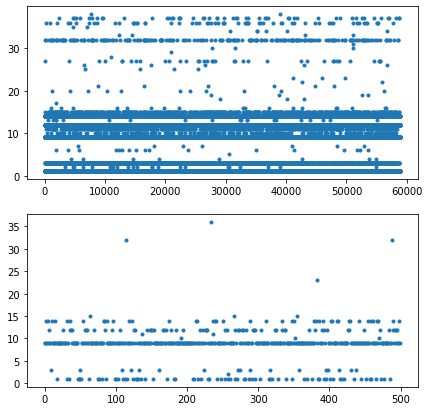

In [101]:
plt.rcParams['figure.figsize'] = (7, 7)
# Employment_Info_2
plt.subplot(2,1,1)
plt.scatter(x=data.index,y=data.Employment_Info_2,marker='.')
plt.subplot(2,1,2)
plt.scatter(x=X_test.index,y=X_test.Employment_Info_2,marker='.')

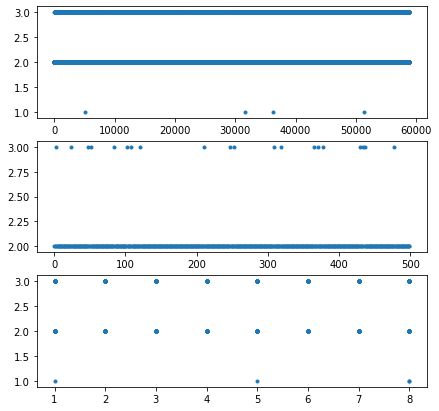

In [103]:
# Medical_History_30
plt.subplot(3,1,1)
plt.scatter(x=data.index,y=data.Medical_History_30,marker='.')
plt.subplot(3,1,2)
plt.scatter(x=X_test.index,y=X_test.Medical_History_30,marker='.')
plt.subplot(3,1,3)
plt.scatter(x=y_data,y=data.Medical_History_30,marker='.')

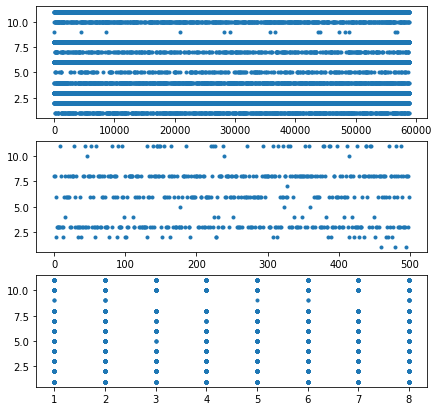

In [104]:
# InsuredInfo_3
plt.subplot(3,1,1)
plt.scatter(x=data.index,y=data.InsuredInfo_3,marker='.')
plt.subplot(3,1,2)
plt.scatter(x=X_test.index,y=X_test.InsuredInfo_3,marker='.')
plt.subplot(3,1,3)
plt.scatter(x=y_data,y=data.InsuredInfo_3,marker='.')

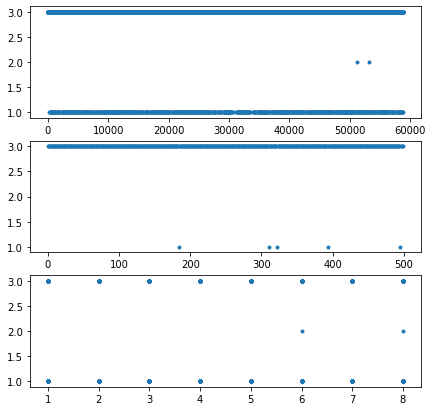

In [105]:
# Medical_History_40
plt.subplot(3,1,1)
plt.scatter(x=data.index,y=data.Medical_History_40,marker='.')
plt.subplot(3,1,2)
plt.scatter(x=X_test.index,y=X_test.Medical_History_40,marker='.')
plt.subplot(3,1,3)
plt.scatter(x=y_data,y=data.Medical_History_40,marker='.')

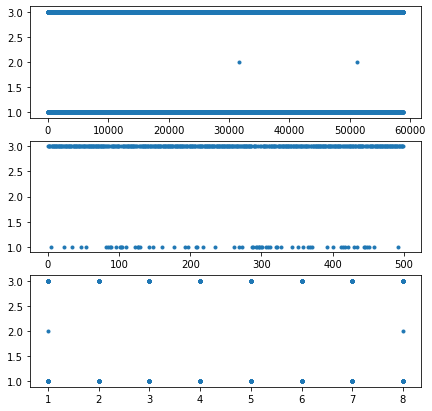

In [106]:
# Medical_History_13
plt.subplot(3,1,1)
plt.scatter(x=data.index,y=data.Medical_History_13,marker='.')
plt.subplot(3,1,2)
plt.scatter(x=X_test.index,y=X_test.Medical_History_13,marker='.')
plt.subplot(3,1,3)
plt.scatter(x=y_data,y=data.Medical_History_13,marker='.')

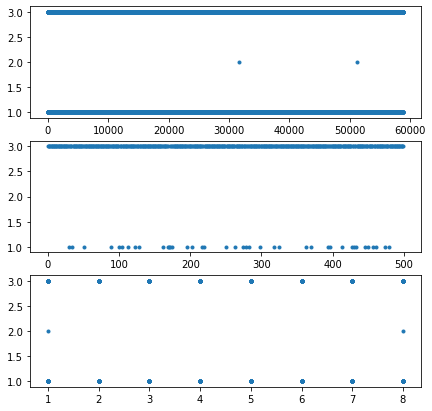

In [107]:
# Medical_History_39
plt.subplot(3,1,1)
plt.scatter(x=data.index,y=data.Medical_History_39,marker='.')
plt.subplot(3,1,2)
plt.scatter(x=X_test.index,y=X_test.Medical_History_39,marker='.')
plt.subplot(3,1,3)
plt.scatter(x=y_data,y=data.Medical_History_39,marker='.')

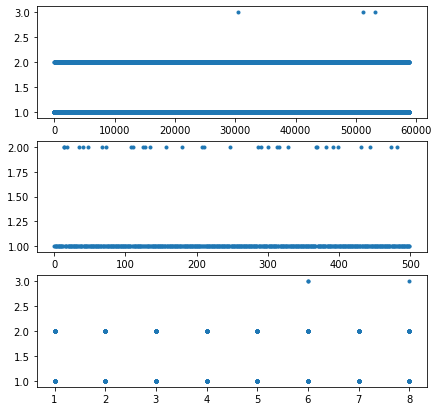

In [108]:
# Medical_History_28
plt.subplot(3,1,1)
plt.scatter(x=data.index,y=data.Medical_History_28,marker='.')
plt.subplot(3,1,2)
plt.scatter(x=X_test.index,y=X_test.Medical_History_28,marker='.')
plt.subplot(3,1,3)
plt.scatter(x=y_data,y=data.Medical_History_28,marker='.')

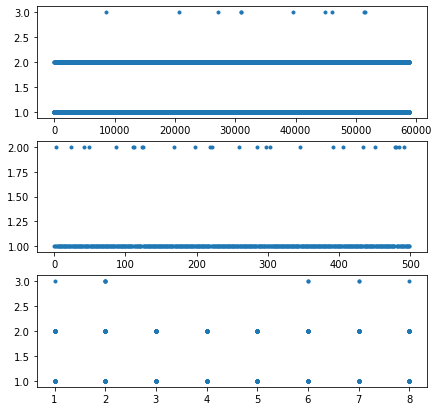

In [109]:
# Medical_History_18
plt.subplot(3,1,1)
plt.scatter(x=data.index,y=data.Medical_History_18,marker='.')
plt.subplot(3,1,2)
plt.scatter(x=X_test.index,y=X_test.Medical_History_18,marker='.')
plt.subplot(3,1,3)
plt.scatter(x=y_data,y=data.Medical_History_18,marker='.')

### Delete outliers in training set and re-train the models

In [133]:
print(data['InsuredInfo_3'].unique())
print(X_test['InsuredInfo_3'].unique())

[ 3  8  4  6 11  2 10  7  5  1]
[ 8  2  6  3 11  4 10  5  7  1]


In [0]:
data = data[important_features]
data['Response'] = y_data

In [164]:
data.drop(data[data['Medical_History_18']==3].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_28']==3].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_39']==2].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_13']==2].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_40']==2].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_30']==1].index,axis=0,inplace=True)
data.drop(data[data['InsuredInfo_3']==9].index,axis=0,inplace=True)

gc.collect()

0

In [169]:
data.reset_index(drop=True,inplace=True)
y_data = data['Response']
del data['Response']
gc.collect()

195

In [170]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data, y_data, 
                                                                test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)

(49997, 35)
(8824, 35)


In [171]:
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=800)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

validation set presicion: 0.5304850407978241
training set precision: 0.5810348620917255


In [190]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_validation.reset_index(drop=True,inplace=True)
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 0
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []
for tr_idx, val_idx in tqdm(kf.split(X_train,y_train)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = X_train[list(X_train)].iloc[tr_idx], y_train[tr_idx]
        vl_x, vl_y = X_train[list(X_train)].iloc[val_idx], y_train[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        clf = xgb.XGBClassifier(n_estimators=1000,
                                learning_rate=0.01,
                                feature_fraction=0.8,
                                max_depth = 10,
                                subsample=0.25,  
                                subsample_freq=1, 
                                lambda_l2=0.8,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models.append(clf)

0it [00:00, ?it/s]

{'train size': 37497, 'eval size': 12500}
[0]	validation_0-merror:0.474651	validation_1-merror:0.51232
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.364829	validation_1-merror:0.46064
[500]	validation_0-merror:0.319866	validation_1-merror:0.45376
[750]	validation_0-merror:0.274742	validation_1-merror:0.45456
Stopping. Best iteration:
[601]	validation_0-merror:0.301864	validation_1-merror:0.45256



1it [01:35, 95.81s/it]

{'train size': 37498, 'eval size': 12499}
[0]	validation_0-merror:0.466105	validation_1-merror:0.513081
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.362153	validation_1-merror:0.464437
[500]	validation_0-merror:0.318924	validation_1-merror:0.459397
[750]	validation_0-merror:0.273081	validation_1-merror:0.456837
Stopping. Best iteration:
[701]	validation_0-merror:0.282735	validation_1-merror:0.456196



2it [03:24, 99.69s/it]

{'train size': 37498, 'eval size': 12499}
[0]	validation_0-merror:0.468905	validation_1-merror:0.511641
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.359966	validation_1-merror:0.460277
[500]	validation_0-merror:0.316497	validation_1-merror:0.457237
[750]	validation_0-merror:0.272041	validation_1-merror:0.458277
Stopping. Best iteration:
[624]	validation_0-merror:0.294949	validation_1-merror:0.455636



3it [05:03, 99.34s/it]

{'train size': 37498, 'eval size': 12499}
[0]	validation_0-merror:0.471198	validation_1-merror:0.508601
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.362979	validation_1-merror:0.461557
[500]	validation_0-merror:0.31959	validation_1-merror:0.458437
[750]	validation_0-merror:0.273188	validation_1-merror:0.454356
Stopping. Best iteration:
[844]	validation_0-merror:0.2566	validation_1-merror:0.452356



4it [07:10, 107.63s/it]


In [191]:
for i in range(4):
  print('model'+str(i),models[i].score(X_validation,y_validation))
print('model'+str(5),clf_rf.score(X_validation,y_validation))

model0 0.550090661831369
model1 0.5523572076155938
model2 0.5534904805077062
model3 0.554283771532185
model5 0.5304850407978241


In [252]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
res_preds.append(clf_rf.predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
print('test set precision hard voting:',accuracy_score(y_validation, res))

res_preds = []
for i in range(3):
  res_preds.append(models[i+1].predict(X_validation))
# res_preds.append(clf_rf.predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(3): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
print('test set precision hard voting:',accuracy_score(y_validation, res))

test set precision hard voting: 0.5540571169537625
test set precision hard voting: 0.5546237533998187


In [0]:
res_preds = []
for i in range(3):
  res_preds.append(models[i+1].predict(X_test))

res = []
for i in range(len(X_test)):
  res_temp = []
  for j in range(3): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))

In [254]:
pred = pd.DataFrame(res)
pred.rename(columns={0:"Response"},inplace=True)
print(pred.shape)

(500, 1)


In [255]:
pred.head(5)

,Response
0,6
1,2
2,5
3,6
4,8
